<a href="https://colab.research.google.com/github/HernanDL/Noise-Cancellation-Using-ML/blob/main/Record_%26_Analyze_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa soundfile matplotlib numpy IPython


In [1]:
import librosa
from google.colab import files

def load_local_audio():
  uploaded = files.upload()
  for file_name in uploaded.keys():
      print(f"Uploaded file: {file_name}")
      audio, sr = librosa.load(file_name, sr=None)  # Load with original sample rate
      return audio, sr, file_name

# Step 1: Load the local audio
audio, sr, file_name = load_local_audio()

Saving extractor_44k.wav to extractor_44k.wav
Uploaded file: extractor_44k.wav


Minimum Frequency: 0.0 Hz
Maximum Frequency: 22049.875108324417 Hz


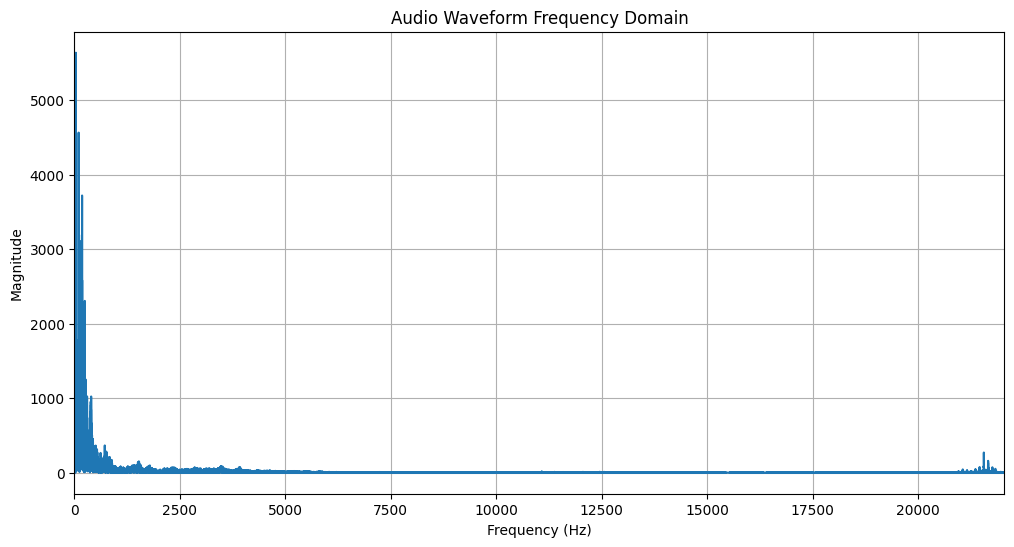

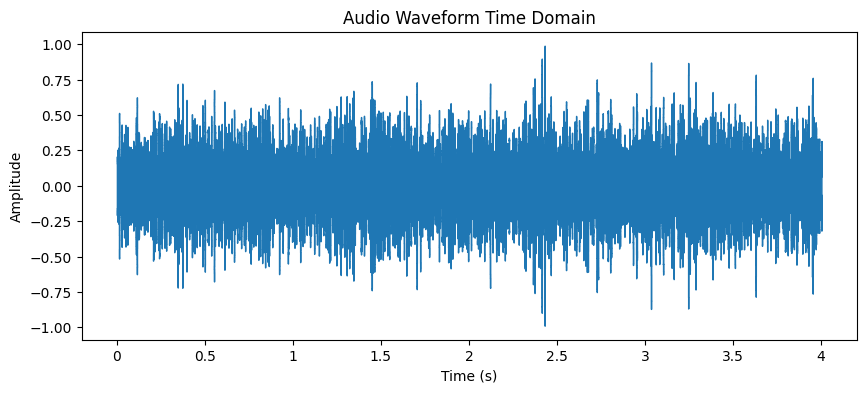

Cutoff frequency for 95.0% retention: 14871.85 Hz


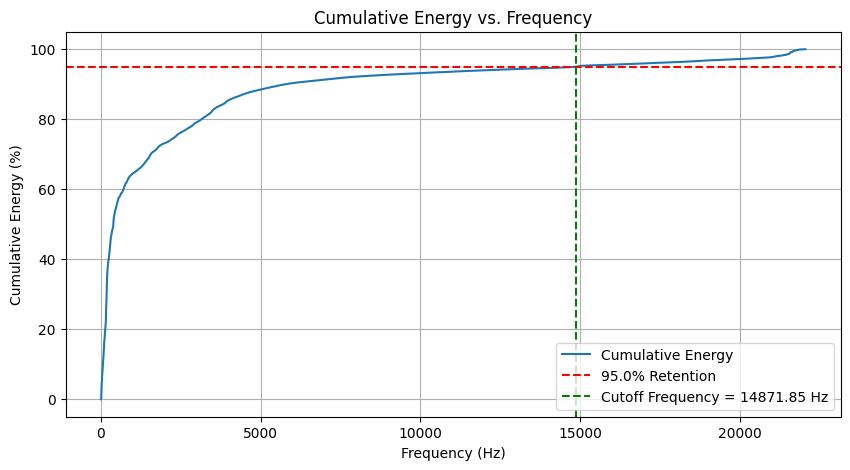

Playing Original Audio:


Playing Resampled Audio (29744 Hz):


Playing Augmented Resampled Audio:


Minimum Frequency: 0.0 Hz
Maximum Frequency: 14871.750218340612 Hz


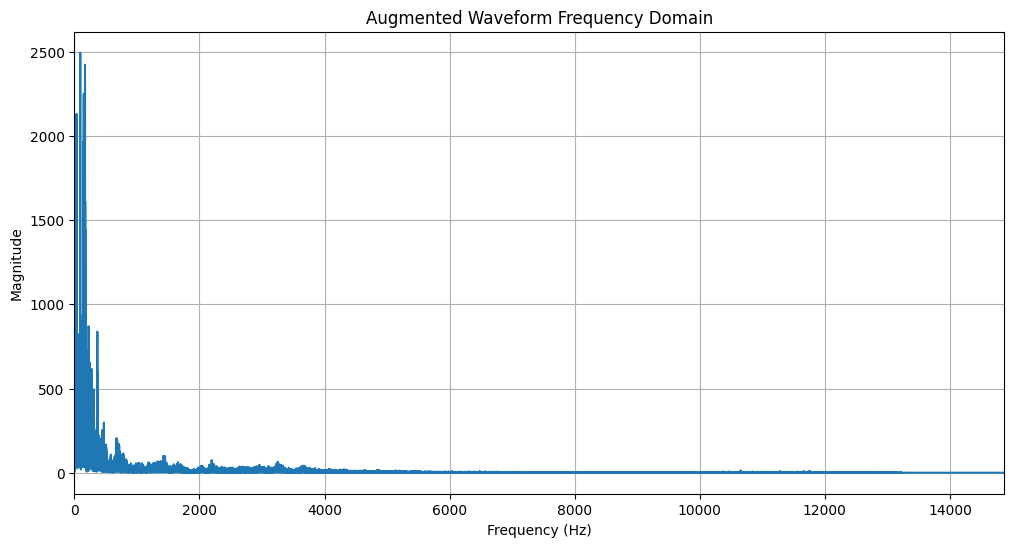

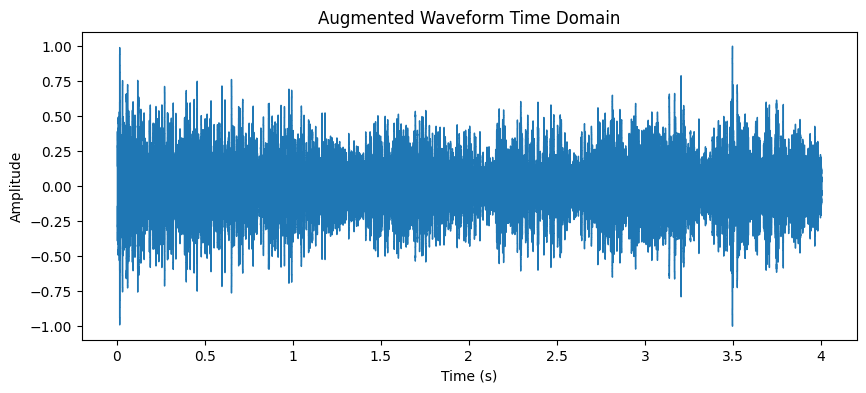

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio

# Analyze the audio (frequency range)
def analyze_audio(audio, sr, title):
    # Perform Fourier Transform
    fft_result = np.fft.fft(audio)
    frequencies = np.fft.fftfreq(len(fft_result), 1/sr)

    # Get the magnitude of the FFT
    magnitude = np.abs(fft_result)

    # Filter out negative frequencies
    positive_frequencies = frequencies[frequencies >= 0]
    positive_magnitude = magnitude[frequencies >= 0]

    # Find minimum and maximum frequencies with non-zero magnitude
    min_freq = positive_frequencies[positive_magnitude > 0].min()
    max_freq = positive_frequencies[positive_magnitude > 0].max()

    print(f"Minimum Frequency: {min_freq} Hz")
    print(f"Maximum Frequency: {max_freq} Hz")

    # Plotting the frequency domain graph
    plt.figure(figsize=(12, 6))
    plt.plot(positive_frequencies, positive_magnitude)
    plt.title(f"{title} Frequency Domain")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0, max_freq)  # Limit x-axis to max frequency for clarity
    plt.grid()
    plt.show()

    # Plot the audio waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f"{title} Time Domain")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    return

import numpy as np
import librosa
import matplotlib.pyplot as plt

def calculate_cutoff_frequency(audio, sr, desired_retention):
    # Perform FFT (Fast Fourier Transform) to get frequency components
    fft = np.fft.fft(audio)
    frequencies = np.fft.fftfreq(len(fft), 1/sr)

    # Calculate the magnitude spectrum
    magnitude = np.abs(fft)

    # Filter positive frequencies only (since FFT is symmetric)
    positive_frequencies = frequencies[:len(frequencies)//2]
    magnitude = magnitude[:len(magnitude)//2]

    # Sort frequencies by magnitude (descending order of energy contribution)
    sorted_indices = np.argsort(positive_frequencies)
    sorted_frequencies = positive_frequencies[sorted_indices]
    sorted_magnitude = magnitude[sorted_indices]

    # Calculate cumulative energy of the signal
    cumulative_energy = np.cumsum(sorted_magnitude)
    total_energy = np.sum(sorted_magnitude)

    # Normalize the cumulative energy to a percentage
    cumulative_energy_percentage = (cumulative_energy / total_energy) * 100

    # Find the cutoff frequency where the desired retention is reached
    cutoff_index = np.where(cumulative_energy_percentage >= desired_retention)[0][0]
    cutoff_frequency = sorted_frequencies[cutoff_index]

    print(f"Cutoff frequency for {desired_retention}% retention: {cutoff_frequency:.2f} Hz")

    # Plot the cumulative energy curve
    plt.figure(figsize=(10, 5))
    plt.plot(sorted_frequencies, cumulative_energy_percentage, label="Cumulative Energy")
    plt.axhline(y=desired_retention, color='r', linestyle='--', label=f"{desired_retention}% Retention")
    plt.axvline(x=cutoff_frequency, color='g', linestyle='--', label=f"Cutoff Frequency = {cutoff_frequency:.2f} Hz")
    plt.title("Cumulative Energy vs. Frequency")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Cumulative Energy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return cutoff_frequency

# Augment the audio (time-stretching, pitch-shifting)
def augment_wave(wave, sample_rate):

    target_length = len(wave)
    # Apply random pitch shift
    pitch_shift = np.random.uniform(-1.5, 1.5)
    wave_augmented = librosa.effects.pitch_shift(wave, sr=sample_rate, n_steps=pitch_shift)

    # Apply random time stretching
    time_stretch_factor = np.random.uniform(0.8, 1.2)
    wave_augmented = librosa.effects.time_stretch(wave_augmented, rate=time_stretch_factor)

    # Normalize augmented wave
    wave_augmented = librosa.util.normalize(wave_augmented)

    # Ensure the length matches the original wave length by padding or truncating
    if len(wave_augmented) > target_length:
        wave_augmented = wave_augmented[:target_length]
    else:
        # Calculate how much padding is needed
        padding_needed = target_length - len(wave_augmented)
        # Slice from the original wave to pad
        wave_augmented = np.concatenate((wave_augmented, wave[:padding_needed]))

    return wave_augmented

def resample_audio(audio, original_sr, target_sr):
    # Resample the audio to the target sample rate
    resampled_audio = librosa.resample(audio, orig_sr=original_sr, target_sr=target_sr)
    return resampled_audio

# Play audio in Colab
def play_audio(audio, sr):
    return Audio(audio, rate=sr)

# Save audio to local machine
def save_audio(file_path, audio, sr):
    sf.write(file_path, audio, sr)
    files.download(file_path)

# Main function to run all steps
def process_audio():
    analyze_audio(audio, sr, "Audio Waveform")

    desired_retention = 95.0  # Set the desired retention percentage
    cutoff_frequency = calculate_cutoff_frequency(audio, sr, desired_retention)
    # Apply Nyquist Theorem: The new sample rate is calculated as 2 × cutoff frequency
    # to ensure you capture all frequencies up to that cutoff without aliasing.
    target_sample_rate = int(np.ceil(2 * cutoff_frequency))
    # Resample the audio to the new sample rate
    resampled_audio = resample_audio(audio, original_sr=sr, target_sr=target_sample_rate)

    augmented_audio = augment_wave(resampled_audio, target_sample_rate)

    print("Playing Original Audio:")
    display(play_audio(audio, sr))

    # Play the resampled audio
    print(f"Playing Resampled Audio ({target_sample_rate} Hz):")
    display(play_audio(resampled_audio, sr=target_sample_rate))

    print("Playing Augmented Resampled Audio:")
    display(play_audio(augmented_audio, sr=target_sample_rate))

    analyze_audio(augmented_audio, target_sample_rate, "Augmented Waveform")

    #save_audio("augmented_" + file_name, augmented_audio, sr)

# Run the process
process_audio()
